# Kevin Egedy
## EE 560 P: Electric Machines and Drives    
## Homework 04
### Due 14 December, 2020

Copyright &copy; 2020, University of Washington

<hr>

In [1]:
# Imports
import re
import sympy as sp
import numpy as np
import pandas as pd
import control
from scipy import signal
from scipy import linalg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", 101)
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# Constants
Vf = 360
radsec2rpm = 30/np.pi

In [2]:
# Constants
f = 1000
Kv = 680

<hr>

### Induction Motor Simulation

#### 1W Motor

In [3]:
# 1W Motor
Va1 = 170
If1 = 0.52
Rf1 = Vf/If1
Lf1 = 0.15
Ra1 = 5.59
La1 = 15.5e-3
wn1 = 1300*np.pi/30
Tr1 = 7.0
J1= 3.2e-3
b1 = 1e-4
Ke1 = Va1/wn1
Kf1 = Ke1/If1
Kt1 = Kf1*If1
K = Ke1
#TauE = La1/Ra1
#TauM = J1*Ra1/(K**2)

#### 90.8 W Motor

In [4]:
# 90.8W Motor
Va91 = 460
If91 = 3.5
Rf91 = Vf/If91
Lf91 = 0.015
Ra91 = 0.09
La91 = 1.0e-3
wn91 = 3000*np.pi/30
Tr91 = 289
J91= 0.2452
b91 = 1e-3
Ke91 = Va91/wn91
Kf91 = Ke91/If91
Kt91 = Kf91*If91
K = Ke91

#### Data Import

In [5]:
myModel = {}
myModel['perf'] = pd.read_csv('../hw03/data/myModel/perf_step.csv',dtype=np.float64)
myModel['rotor'] = pd.read_csv('../hw03/data/myModel/rotor_currents.csv',dtype=np.float64)
myModel['stator'] = pd.read_csv('../hw03/data/myModel/stator_currents.csv',dtype=np.float64)

plecs = {}
plecs['perf'] = pd.read_csv('../hw03/data/plecs/perf_step.csv',dtype=np.float64)
plecs['rotor'] = pd.read_csv('../hw03/data/plecs/rotor_currents.csv',dtype=np.float64)
plecs['stator'] = pd.read_csv('../hw03/data/plecs/stator_currents.csv',dtype=np.float64)

In [6]:
myModel['perf'].columns

Index(['Time', 'Rotor  Speed:Speed', '(3/2)*p*Lm', 'Step'], dtype='object')

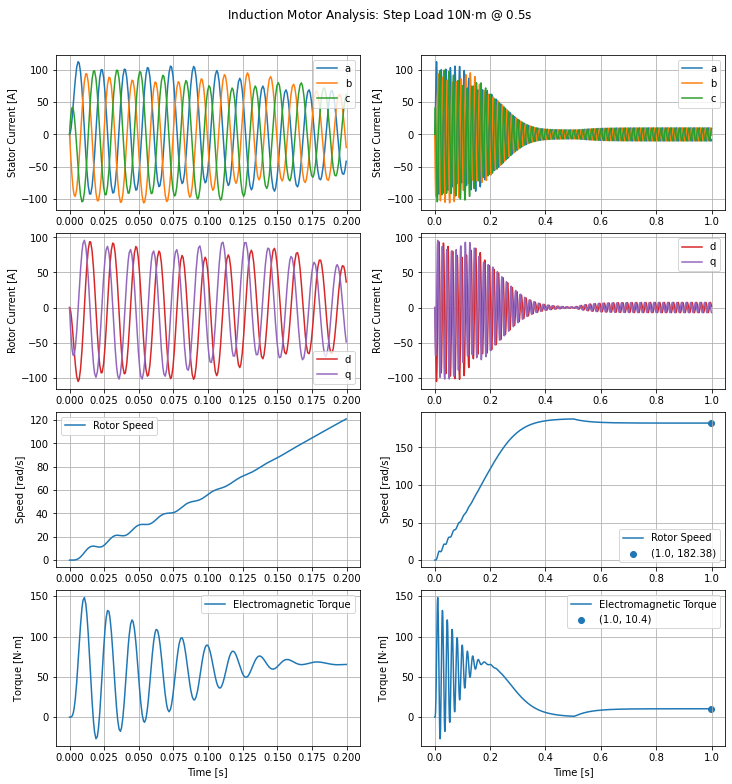

In [7]:
fig,axs = plt.subplots(4,2,figsize=(12,12))
plt.subplots_adjust(top=0.925,hspace=0.15)

df = myModel['stator'];myModel['stator'] = df[df['Time']<1]
df = myModel['rotor'];myModel['rotor'] = df[df['Time']<1]
df = myModel['perf'];myModel['perf'] = df[df['Time']<1]

labels = ['a','b','c']
for i,c in enumerate(myModel['stator'].drop('Time',axis=1).columns):
    axs[0,1].plot(myModel['stator'].Time,myModel['stator'][c],label=f'{labels[i]}')
    axs[0,1].set_ylabel('Stator Current [A]')
    axs[0,1].grid(True)
    axs[0,1].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(myModel['rotor'].drop('Time',axis=1).columns):
    axs[1,1].plot(myModel['rotor'].Time,myModel['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,1].set_ylabel('Rotor Current [A]')
    axs[1,1].grid(True)
    axs[1,1].legend()

labels = ['Rotor Speed']
axs[2,1].plot(myModel['perf'].Time,myModel['perf']['Rotor  Speed:Speed'],label=f'{labels[0]}')
axs[2,1].scatter(
    myModel['perf'].Time.values[-1],
    myModel['perf']['Rotor  Speed:Speed'].values[-1],
    label=f"({round(myModel['perf'].Time.values[-1],2)}, {round(myModel['perf']['Rotor  Speed:Speed'].values[-1],2)})"
)
axs[2,1].set_ylabel('Speed [rad/s]')
axs[2,1].grid(True)
axs[2,1].legend()

labels = ['Electromagnetic Torque']
axs[3,1].plot(myModel['perf'].Time,myModel['perf']['(3/2)*p*Lm'],label=f'{labels[0]}')
axs[3,1].scatter(
    myModel['perf'].Time.values[-1],
    myModel['perf']['(3/2)*p*Lm'].values[-1],
    label=f"({round(myModel['perf'].Time.values[-1],2)}, {round(myModel['perf']['(3/2)*p*Lm'].values[-1],2)})"
)
axs[3,1].set_ylabel('Torque [N$\cdot$m]')
axs[3,1].set_xlabel('Time [s]')
axs[3,1].grid(True)
axs[3,1].legend()

df = myModel['stator'];myModel['stator'] = df[df['Time']<0.2]
df = myModel['rotor'];myModel['rotor'] = df[df['Time']<0.2]
df = myModel['perf'];myModel['perf'] = df[df['Time']<0.2]

labels = ['a','b','c']
for i,c in enumerate(myModel['stator'].drop('Time',axis=1).columns):
    axs[0,0].plot(myModel['stator'].Time,myModel['stator'][c],label=f'{labels[i]}')
    axs[0,0].set_ylabel('Stator Current [A]')
    axs[0,0].grid(True)
    axs[0,0].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(myModel['rotor'].drop('Time',axis=1).columns):
    axs[1,0].plot(myModel['rotor'].Time,myModel['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Rotor Current [A]')
    axs[1,0].grid(True)
    axs[1,0].legend()

labels = ['Rotor Speed']
axs[2,0].plot(myModel['perf'].Time,myModel['perf']['Rotor  Speed:Speed'],label=f'{labels[0]}')
axs[2,0].set_ylabel('Speed [rad/s]')
axs[2,0].grid(True)
axs[2,0].legend()

labels = ['Electromagnetic Torque']
axs[3,0].plot(myModel['perf'].Time,myModel['perf']['(3/2)*p*Lm'],label=f'{labels[0]}')
axs[3,0].set_ylabel('Torque [N$\cdot$m]')
axs[3,0].set_xlabel('Time [s]')
axs[3,0].grid(True)
axs[3,0].legend()

plt.suptitle('Induction Motor Analysis: Step Load 10N$\cdot$m @ 0.5s')
plt.show();

In [8]:
plecs['perf'].columns

Index(['Time', 'Squirrel-Cage IM:Rotational speed',
       'Squirrel-Cage IM:Electrical torque', 'Step:Output'],
      dtype='object')

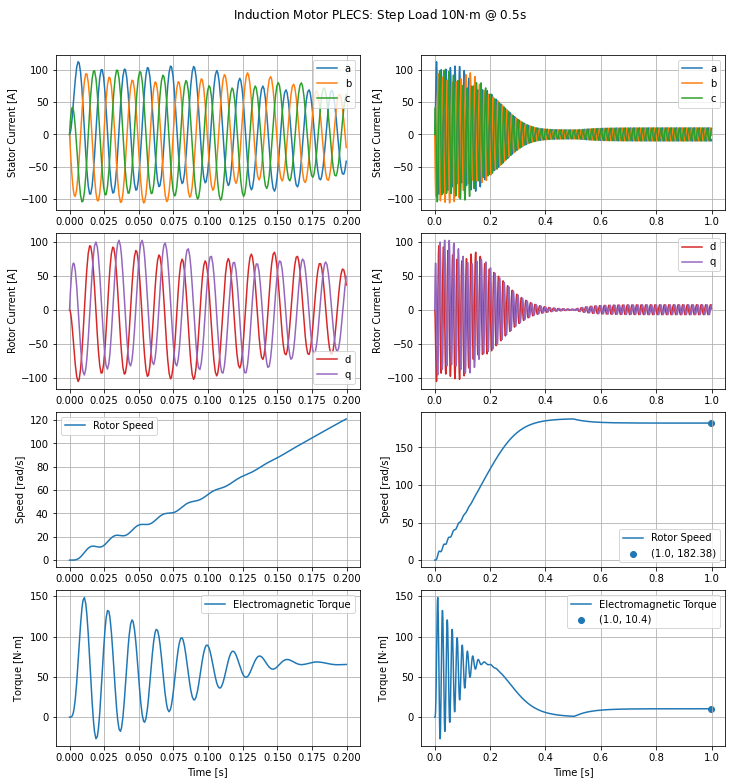

In [9]:
fig,axs = plt.subplots(4,2,figsize=(12,12))
plt.subplots_adjust(top=0.925,hspace=0.15)

df = plecs['stator'];plecs['stator'] = df[df['Time']<1]
df = plecs['rotor'];plecs['rotor'] = df[df['Time']<1]
df = plecs['perf'];plecs['perf'] = df[df['Time']<1]

labels = ['a','b','c']
for i,c in enumerate(plecs['stator'].drop('Time',axis=1).columns):
    axs[0,1].plot(plecs['stator'].Time,plecs['stator'][c],label=f'{labels[i]}')
    axs[0,1].set_ylabel('Current [A]')
    axs[0,1].set_ylabel('Stator Current [A]')
    axs[0,1].grid(True)
    axs[0,1].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(plecs['rotor'].drop('Time',axis=1).columns):
    axs[1,1].plot(plecs['rotor'].Time,plecs['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,1].set_ylabel('Current [A]')
    axs[1,1].set_ylabel('Rotor Current [A]')
    axs[1,1].grid(True)
    axs[1,1].legend()

labels = ['Rotor Speed']
axs[2,1].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Rotational speed'],label=f'{labels[0]}')
axs[2,1].scatter(
    plecs['perf'].Time.values[-1],
    plecs['perf']['Squirrel-Cage IM:Rotational speed'].values[-1],
    label=f"({round(plecs['perf'].Time.values[-1],2)}, {round(plecs['perf']['Squirrel-Cage IM:Rotational speed'].values[-1],2)})"
)
axs[2,1].set_ylabel('Speed [rad/s]')
axs[2,1].grid(True)
axs[2,1].legend()

labels = ['Electromagnetic Torque']
axs[3,1].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Electrical torque'],label=f'{labels[0]}')
axs[3,1].scatter(
    plecs['perf'].Time.values[-1],
    plecs['perf']['Squirrel-Cage IM:Electrical torque'].values[-1],
    label=f"({round(plecs['perf'].Time.values[-1],2)}, {round(plecs['perf']['Squirrel-Cage IM:Electrical torque'].values[-1],2)})"
)
axs[3,1].set_ylabel('Torque [N$\cdot$m]')
axs[3,1].set_xlabel('Time [s]')
axs[3,1].grid(True)
axs[3,1].legend()

df = plecs['stator'];plecs['stator'] = df[df['Time']<0.2]
df = plecs['rotor'];plecs['rotor'] = df[df['Time']<0.2]
df = plecs['perf'];plecs['perf'] = df[df['Time']<0.2]

labels = ['a','b','c']
for i,c in enumerate(plecs['stator'].drop('Time',axis=1).columns):
    axs[0,0].plot(plecs['stator'].Time,plecs['stator'][c],label=f'{labels[i]}')
    axs[0,0].set_ylabel('Stator Current [A]')
    axs[0,0].grid(True)
    axs[0,0].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(plecs['rotor'].drop('Time',axis=1).columns):
    axs[1,0].plot(plecs['rotor'].Time,plecs['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Rotor Current [A]')
    axs[1,0].grid(True)
    axs[1,0].legend()

labels = ['Rotor Speed']
axs[2,0].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Rotational speed'],label=f'{labels[0]}')
axs[2,0].set_ylabel('Speed [rad/s]')
axs[2,0].grid(True)
axs[2,0].legend()

labels = ['Electromagnetic Torque']
axs[3,0].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Electrical torque'],label=f'{labels[0]}')
axs[3,0].set_ylabel('Torque [N$\cdot$m]')
axs[3,0].set_xlabel('Time [s]')
axs[3,0].grid(True)
axs[3,0].legend()

plt.suptitle('Induction Motor PLECS: Step Load 10N$\cdot$m @ 0.5s')
plt.show();

In [10]:
myModel = {}
myModel['perf'] = pd.read_csv('../hw03/data/myModel/perf_step.csv',dtype=np.float64)
myModel['rotor'] = pd.read_csv('../hw03/data/myModel/rotor_currents.csv',dtype=np.float64)
myModel['stator'] = pd.read_csv('../hw03/data/myModel/stator_currents.csv',dtype=np.float64)

plecs = {}
plecs['perf'] = pd.read_csv('../hw03/data/plecs/perf_step.csv',dtype=np.float64)
plecs['rotor'] = pd.read_csv('../hw03/data/plecs/rotor_currents.csv',dtype=np.float64)
plecs['stator'] = pd.read_csv('../hw03/data/plecs/stator_currents.csv',dtype=np.float64)

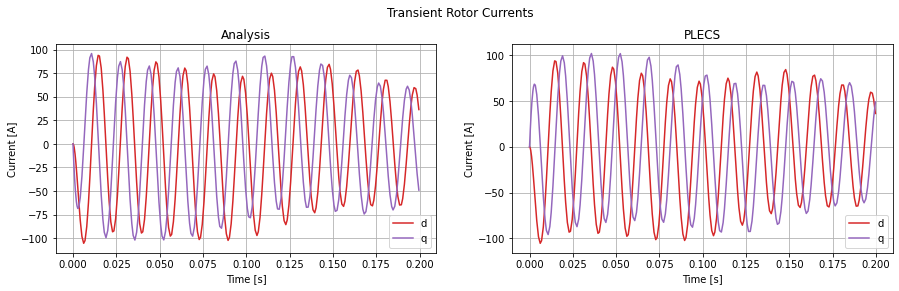

In [11]:
fig,axs = plt.subplots(1,2,figsize=(15,4))
plt.subplots_adjust(top=0.85,hspace=0.15)

df = myModel['stator'];myModel['stator'] = df[df['Time']<0.2]
df = myModel['rotor'];myModel['rotor'] = df[df['Time']<0.2]
df = myModel['perf'];myModel['perf'] = df[df['Time']<0.2]

df = plecs['stator'];plecs['stator'] = df[df['Time']<0.2]
df = plecs['rotor'];plecs['rotor'] = df[df['Time']<0.2]
df = plecs['perf'];plecs['perf'] = df[df['Time']<0.2]

# MYMODEL
labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(myModel['rotor'].drop('Time',axis=1).columns):
    axs[0].plot(myModel['rotor'].Time,myModel['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0].set_ylabel('Current [A]')
    axs[0].set_xlabel('Time [s]')
    axs[0].grid(True)
    axs[0].set_title('Analysis')
    axs[0].legend(loc='lower right')

# PLECS
labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(plecs['rotor'].drop('Time',axis=1).columns):
    axs[1].plot(plecs['rotor'].Time,plecs['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1].set_ylabel('Current [A]')
    axs[1].set_xlabel('Time [s]')
    axs[1].grid(True)
    axs[1].set_title('PLECS')
    axs[1].legend(loc='lower right')

plt.suptitle('Transient Rotor Currents')
plt.show();

<hr>

### Tesla Simulation

In [12]:
locked_torque_step = {}
locked_torque_step['Iqd_e'] = pd.read_csv('data/locked_torque_step/Iqd_e.csv',dtype=np.float64)
locked_torque_step['Iqd_s'] = pd.read_csv('data/locked_torque_step/Iqd_s.csv',dtype=np.float64)
locked_torque_step['Tem'] = pd.read_csv('data/locked_torque_step/Tem.csv',dtype=np.float64)

In [13]:
locked_torque_step['Tem'].columns

Index(['Time', 'Tem*1', 'Tem'], dtype='object')

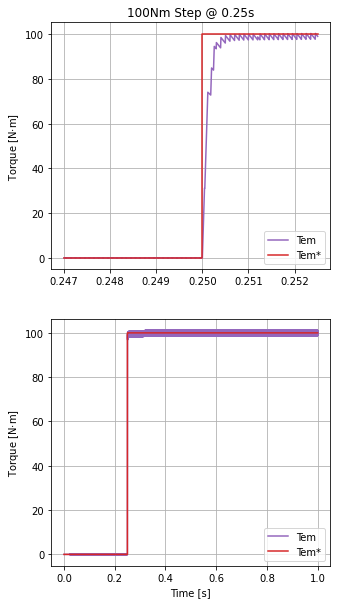

In [14]:
fig,axs = plt.subplots(2,1,figsize=(5,10))
labels = ['Tem','Tem*']
colors = ['tab:purple','tab:red']

df = locked_torque_step['Tem']
for i,c in enumerate(['Tem','Tem*1']):
    axs[1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1].set_ylabel('Torque [N$\cdot$m]')
    axs[1].set_xlabel('Time [s]')
    axs[1].grid(True)
    #axs[1].set_title('100Nm Step @ 0.25s')
    axs[1].legend(loc='lower right')
    
df = df[(df['Time']>0.247) & (df['Time']<0.2525)]
for i,c in enumerate(['Tem','Tem*1']):
    axs[0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0].set_ylabel('Torque [N$\cdot$m]')
    #axs[0].set_xlabel('Time [s]')
    axs[0].grid(True)
    axs[0].set_title('100Nm Step @ 0.25s')
    axs[0].legend(loc='lower right')
    
plt.show();

In [15]:
df = locked_torque_step['Iqd_s']
df.columns

Index(['Time', 'Iqs*', 'Iqs', 'Ids*', 'Ids'], dtype='object')

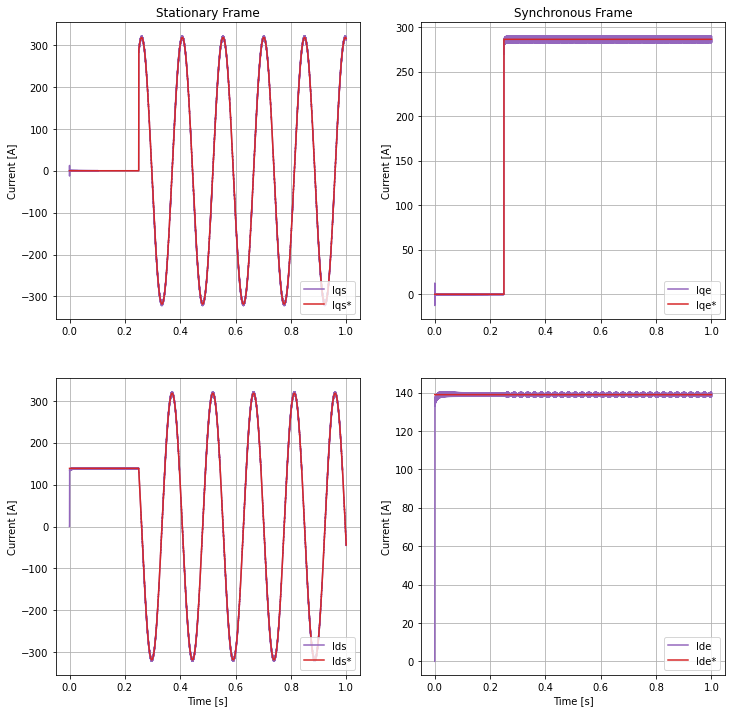

In [16]:
fig,axs = plt.subplots(2,2,figsize=(12,12))
colors = ['tab:purple','tab:red']
df = locked_torque_step['Iqd_s']

labels = ['Iqs','Iqs*']
for i,c in enumerate(['Iqs','Iqs*']):
    axs[0,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0,0].set_ylabel('Current [A]')
    #axs[0].set_xlabel('Time [s]')
    axs[0,0].grid(True)
    axs[0,0].set_title('Stationary Frame')
    axs[0,0].legend(loc='lower right')
    
labels = ['Ids','Ids*']
for i,c in enumerate(['Ids','Ids*']):
    axs[1,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Current [A]')
    axs[1,0].set_xlabel('Time [s]')
    axs[1,0].grid(True)
    #axs[1,0].set_title('100Nm Step @ 0.25s')
    axs[1,0].legend(loc='lower right')

df = locked_torque_step['Iqd_e']

labels = ['Iqe','Iqe*']
for i,c in enumerate(['Iqe','Iqe*']):
    axs[0,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0,1].set_ylabel('Current [A]')
    #axs[0,1].set_xlabel('Time [s]')
    axs[0,1].grid(True)
    axs[0,1].set_title('Synchronous Frame')
    axs[0,1].legend(loc='lower right')
    
labels = ['Ide','Ide*']
for i,c in enumerate(['Ide','Ide*']):
    axs[1,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,1].set_ylabel('Current [A]')
    axs[1,1].set_xlabel('Time [s]')
    axs[1,1].grid(True)
    #axs[1,1].set_title('100Nm Step @ 0.25s')
    axs[1,1].legend(loc='lower right')
    
plt.show();

In [17]:
locked_torque_sinusoid_10 = {}
locked_torque_sinusoid_100 = {}
locked_torque_sinusoid_1000 = {}

locked_torque_sinusoid_10['Iqd_e'] = pd.read_csv('data/locked_torque_sinusoid/10Hz/Iqd_e.csv',dtype=np.float64)
locked_torque_sinusoid_10['Iqd_s'] = pd.read_csv('data/locked_torque_sinusoid/10Hz/Iqd_s.csv',dtype=np.float64)
locked_torque_sinusoid_10['Tem'] = pd.read_csv('data/locked_torque_sinusoid/10Hz/Tem.csv',dtype=np.float64)

locked_torque_sinusoid_100['Iqd_e'] = pd.read_csv('data/locked_torque_sinusoid/100Hz/Iqd_e.csv',dtype=np.float64)
locked_torque_sinusoid_100['Iqd_s'] = pd.read_csv('data/locked_torque_sinusoid/100Hz/Iqd_s.csv',dtype=np.float64)
locked_torque_sinusoid_100['Tem'] = pd.read_csv('data/locked_torque_sinusoid/100Hz/Tem.csv',dtype=np.float64)

locked_torque_sinusoid_1000['Iqd_e'] = pd.read_csv('data/locked_torque_sinusoid/1000Hz/Iqd_e.csv',dtype=np.float64)
locked_torque_sinusoid_1000['Iqd_s'] = pd.read_csv('data/locked_torque_sinusoid/1000Hz/Iqd_s.csv',dtype=np.float64)
locked_torque_sinusoid_1000['Tem'] = pd.read_csv('data/locked_torque_sinusoid/1000Hz/Tem.csv',dtype=np.float64)

In [18]:
df = locked_torque_sinusoid_10['Tem']
df.columns

Index(['Time', 'Tem*1', 'Tem'], dtype='object')

100.69266865256044
85.65694049932094


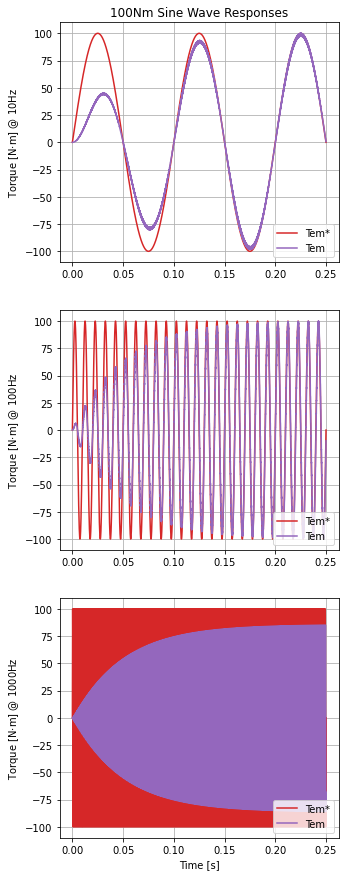

In [19]:
fig,axs = plt.subplots(3,1,figsize=(5,15))
labels = ['Tem*','Tem']
colors = ['tab:red','tab:purple']

df = locked_torque_sinusoid_10['Tem']
df = df[df['Time']<0.25]
for i,c in enumerate(['Tem*1','Tem']):
    axs[0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0].set_ylabel('Torque [N$\cdot$m] @ 10Hz')
    #axs[0].set_xlabel('Time [s]')
    axs[0].grid(True)
    axs[0].set_title('100Nm Sine Wave Responses')
    axs[0].legend(loc='lower right')
    
df = locked_torque_sinusoid_100['Tem']
print(df['Tem'].max())
df = df[df['Time']<0.25]
for i,c in enumerate(['Tem*1','Tem']):
    axs[1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1].set_ylabel('Torque [N$\cdot$m] @ 100Hz')
    #axs[1].set_xlabel('Time [s]')
    axs[1].grid(True)
    #axs[1].set_title('100Nm Step @ 0.25s')
    axs[1].legend(loc='lower right')

df = locked_torque_sinusoid_1000['Tem']
print(df['Tem'].max())
df = df[df['Time']<0.25]
for i,c in enumerate(['Tem*1','Tem']):
    axs[2].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[2].set_ylabel('Torque [N$\cdot$m] @ 1000Hz')
    axs[2].set_xlabel('Time [s]')
    axs[2].grid(True)
    #axs[2].set_title('100Nm Step @ 0.25s')
    axs[2].legend(loc='lower right')
    
plt.show();

85.65694049932094


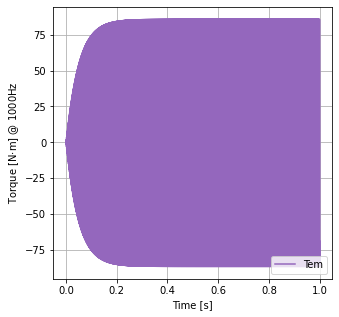

In [20]:
fig,axs = plt.subplots(1,figsize=(5,5))
labels = ['Tem']
colors = ['tab:purple']

df = locked_torque_sinusoid_1000['Tem']
print(df['Tem'].max())
#df = df[df['Time']<0.25]
for i,c in enumerate(['Tem']):
    axs.plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs.set_ylabel('Torque [N$\cdot$m] @ 1000Hz')
    axs.set_xlabel('Time [s]')
    axs.grid(True)
    #axs.set_title('100Nm Step @ 0.25s')
    axs.legend(loc='lower right')
    
plt.show();

In [21]:
df = locked_torque_sinusoid_10['Iqd_e']
df.columns

Index(['Time', 'Iqe*', 'Iqe', 'Ide*', 'Ide'], dtype='object')

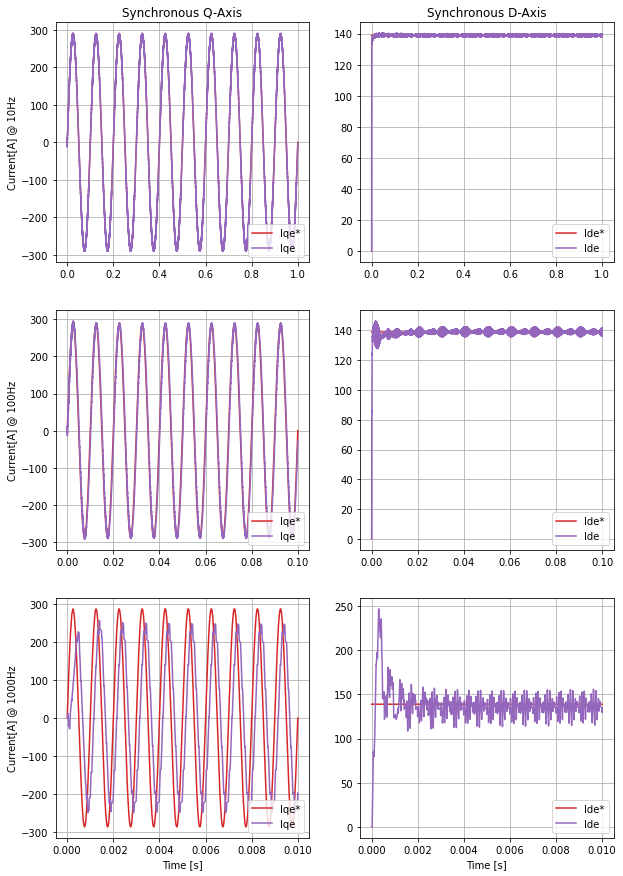

In [22]:
fig,axs = plt.subplots(3,2,figsize=(10,15))
labels = ['Iqe*','Iqe']
colors = ['tab:red','tab:purple']

df = locked_torque_sinusoid_10['Iqd_e']
df = df[df['Time']<1]
for i,c in enumerate(['Iqe*','Iqe']):
    axs[0,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0,0].set_ylabel('Current[A] @ 10Hz')
    #axs[0,0].set_xlabel('Time [s]')
    axs[0,0].grid(True)
    axs[0,0].set_title('Synchronous Q-Axis')
    axs[0,0].legend(loc='lower right')
    
df = locked_torque_sinusoid_100['Iqd_e']
df = df[df['Time']<0.1]
for i,c in enumerate(['Iqe*','Iqe']):
    axs[1,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Current[A] @ 100Hz')
    #axs[1,0].set_xlabel('Time [s]')
    axs[1,0].grid(True)
    #axs[1,0].set_title('100Nm Step @ 0.25s')
    axs[1,0].legend(loc='lower right')

df = locked_torque_sinusoid_1000['Iqd_e']
df = df[df['Time']<0.01]
for i,c in enumerate(['Iqe*','Iqe']):
    axs[2,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[2,0].set_ylabel('Current[A] @ 1000Hz')
    axs[2,0].set_xlabel('Time [s]')
    axs[2,0].grid(True)
    #axs[2,0].set_title('100Nm Step @ 0.25s')
    axs[2,0].legend(loc='lower right')
    
    
labels = ['Ide*','Ide']

df = locked_torque_sinusoid_10['Iqd_e']
df = df[df['Time']<1]
for i,c in enumerate(['Ide*','Ide']):
    axs[0,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    #axs[0,1].set_ylabel('Current[A] @ 10Hz')
    #axs[0,1].set_xlabel('Time [s]')
    axs[0,1].grid(True)
    axs[0,1].set_title('Synchronous D-Axis')
    axs[0,1].legend(loc='lower right')
    
df = locked_torque_sinusoid_100['Iqd_e']
df = df[df['Time']<0.1]
for i,c in enumerate(['Ide*','Ide']):
    axs[1,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    #axs[1,1].set_ylabel('Current[A] @ 100Hz')
    #axs[1,1].set_xlabel('Time [s]')
    axs[1,1].grid(True)
    #axs[1,1].set_title('100Nm Step @ 0.25s')
    axs[1,1].legend(loc='lower right')

df = locked_torque_sinusoid_1000['Iqd_e']
df = df[df['Time']<0.01]
for i,c in enumerate(['Ide*','Ide']):
    axs[2,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    #axs[2,1].set_ylabel('Current[A] @ 1000Hz')
    axs[2,1].set_xlabel('Time [s]')
    axs[2,1].grid(True)
    #axs[2,1].set_title('100Nm Step @ 0.25s')
    axs[2,1].legend(loc='lower right')
    
plt.show();

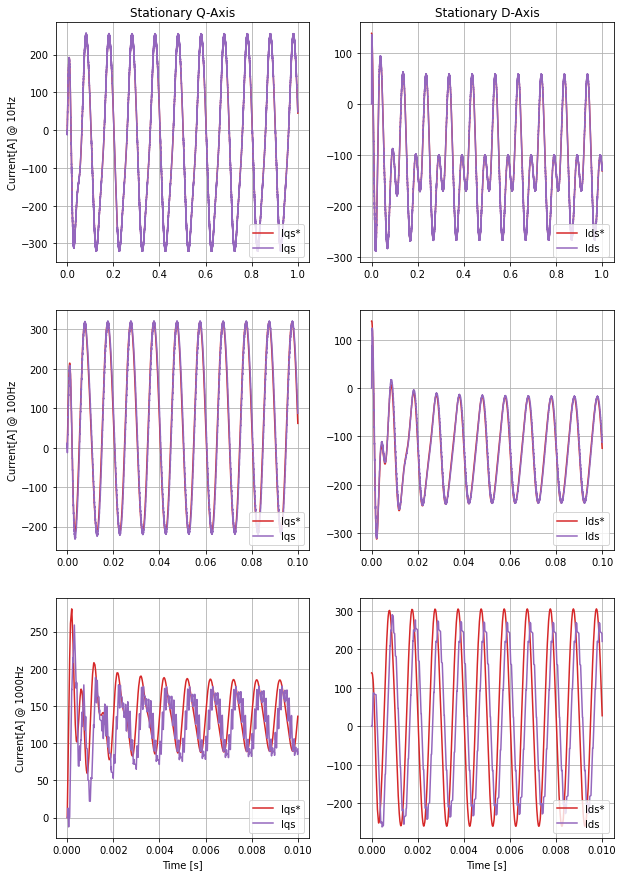

In [23]:
fig,axs = plt.subplots(3,2,figsize=(10,15))
labels = ['Iqs*','Iqs']
colors = ['tab:red','tab:purple']

df = locked_torque_sinusoid_10['Iqd_s']
df = df[df['Time']<1]
for i,c in enumerate(['Iqs*','Iqs']):
    axs[0,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0,0].set_ylabel('Current[A] @ 10Hz')
    #axs[0,0].set_xlabel('Time [s]')
    axs[0,0].grid(True)
    axs[0,0].set_title('Stationary Q-Axis')
    axs[0,0].legend(loc='lower right')
    
df = locked_torque_sinusoid_100['Iqd_s']
df = df[df['Time']<0.1]
for i,c in enumerate(['Iqs*','Iqs']):
    axs[1,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Current[A] @ 100Hz')
    #axs[1,0].set_xlabel('Time [s]')
    axs[1,0].grid(True)
    #axs[1,0].set_title('100Nm Step @ 0.25s')
    axs[1,0].legend(loc='lower right')

df = locked_torque_sinusoid_1000['Iqd_s']
df = df[df['Time']<0.01]
for i,c in enumerate(['Iqs*','Iqs']):
    axs[2,0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[2,0].set_ylabel('Current[A] @ 1000Hz')
    axs[2,0].set_xlabel('Time [s]')
    axs[2,0].grid(True)
    #axs[2,0].set_title('100Nm Step @ 0.25s')
    axs[2,0].legend(loc='lower right')
    
    
labels = ['Ids*','Ids']

df = locked_torque_sinusoid_10['Iqd_s']
df = df[df['Time']<1]
for i,c in enumerate(['Ids*','Ids']):
    axs[0,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    #axs[0,1].set_ylabel('Current[A] @ 10Hz')
    #axs[0,1].set_xlabel('Time [s]')
    axs[0,1].grid(True)
    axs[0,1].set_title('Stationary D-Axis')
    axs[0,1].legend(loc='lower right')
    
df = locked_torque_sinusoid_100['Iqd_s']
df = df[df['Time']<0.1]
for i,c in enumerate(['Ids*','Ids']):
    axs[1,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    #axs[1,1].set_ylabel('Current[A] @ 100Hz')
    #axs[1,1].set_xlabel('Time [s]')
    axs[1,1].grid(True)
    #axs[1,1].set_title('100Nm Step @ 0.25s')
    axs[1,1].legend(loc='lower right')

df = locked_torque_sinusoid_1000['Iqd_s']
df = df[df['Time']<0.01]
for i,c in enumerate(['Ids*','Ids']):
    axs[2,1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    #axs[2,1].set_ylabel('Current[A] @ 1000Hz')
    axs[2,1].set_xlabel('Time [s]')
    axs[2,1].grid(True)
    #axs[2,1].set_title('100Nm Step @ 0.25s')
    axs[2,1].legend(loc='lower right')
    
plt.show();

In [41]:
unlocked_speed_sinusoid_5 = {}
unlocked_speed_sinusoid_50 = {}

unlocked_speed_sinusoid_5['Iqd_e'] = pd.read_csv('data/unlocked_speed_sinusoid/5Hz/Iqd_e.csv',dtype=np.float64)
unlocked_speed_sinusoid_5['Iqd_s'] = pd.read_csv('data/unlocked_speed_sinusoid/5Hz/Iqd_s.csv',dtype=np.float64)
unlocked_speed_sinusoid_5['Tem'] = pd.read_csv('data/unlocked_speed_sinusoid/5Hz/Tem.csv',dtype=np.float64)
unlocked_speed_sinusoid_5['wrm'] = pd.read_csv('data/unlocked_speed_sinusoid/5Hz/wrm.csv',dtype=np.float64)

unlocked_speed_sinusoid_50['Iqd_e'] = pd.read_csv('data/unlocked_speed_sinusoid/50Hz/Iqd_e.csv',dtype=np.float64)
unlocked_speed_sinusoid_50['Iqd_s'] = pd.read_csv('data/unlocked_speed_sinusoid/50Hz/Iqd_s.csv',dtype=np.float64)
unlocked_speed_sinusoid_50['Tem'] = pd.read_csv('data/unlocked_speed_sinusoid/50Hz/Tem.csv',dtype=np.float64)
unlocked_speed_sinusoid_50['wrm'] = pd.read_csv('data/unlocked_speed_sinusoid/50Hz/wrm.csv',dtype=np.float64)

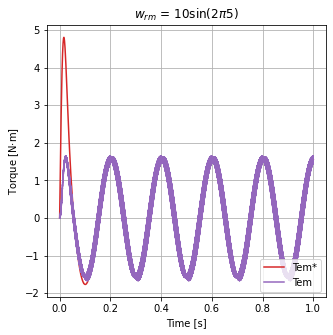

In [47]:
fig,axs = plt.subplots(1,figsize=(5,5))
labels = ['Tem*','Tem']
colors = ['tab:red','tab:purple']

df = unlocked_speed_sinusoid_5['Tem']
for i,c in enumerate(['Tem*1','Tem']):
    axs.plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs.set_ylabel('Torque [N$\cdot$m]')
    axs.set_xlabel('Time [s]')
    axs.grid(True)
    axs.set_title('$w_{rm}$ = 10sin(2$\pi$5)')
    axs.legend(loc='lower right')

plt.show();

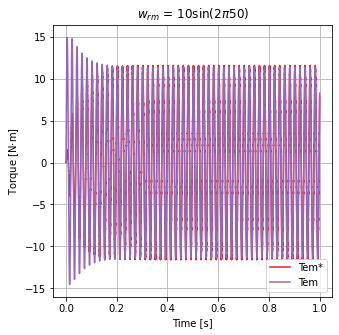

In [40]:
fig,axs = plt.subplots(1,figsize=(5,5))
labels = ['Tem*','Tem']
colors = ['tab:red','tab:purple']

df = unlocked_speed_sinusoid_50['Tem']
for i,c in enumerate(['Tem','Tem*1']):
    axs.plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs.set_ylabel('Torque [N$\cdot$m]')
    axs.set_xlabel('Time [s]')
    axs.grid(True)
    axs.set_title('$w_{rm}$ = 10sin(2$\pi$50)')
    axs.legend(loc='lower right')
    
plt.show();

In [43]:
df = unlocked_speed_sinusoid_5['wrm']
df.columns

Index(['Time', 'wrm*1', 'wrm1:Speed'], dtype='object')

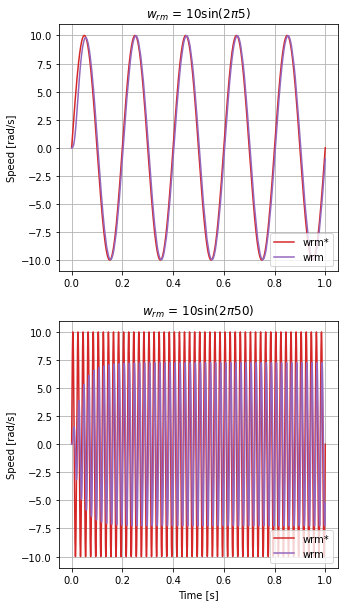

In [49]:
fig,axs = plt.subplots(2,1,figsize=(5,10))
labels = ['wrm*','wrm']
colors = ['tab:red','tab:purple']

df = unlocked_speed_sinusoid_5['wrm']
for i,c in enumerate(['wrm*1','wrm1:Speed']):
    axs[0].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0].set_ylabel('Speed [rad/s]')
    #axs[0].set_xlabel('Time [s]')
    axs[0].grid(True)
    axs[0].set_title('$w_{rm}$ = 10sin(2$\pi$5)')
    axs[0].legend(loc='lower right')
    
df = unlocked_speed_sinusoid_50['wrm']
for i,c in enumerate(['wrm*1','wrm1:Speed']):
    axs[1].plot(df.Time,df[c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1].set_ylabel('Speed [rad/s]')
    axs[1].set_xlabel('Time [s]')
    axs[1].grid(True)
    axs[1].set_title('$w_{rm}$ = 10sin(2$\pi$50)')
    axs[1].legend(loc='lower right')
    
plt.show();